<a href="https://colab.research.google.com/github/NIKITOOOK/Brain-tumor/blob/main/EfficientNetB0_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub tensorflow numpy matplotlib pandas scikit-learn

In [ ]:
# Импорт библиотек
import kagglehub
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ultralytics/brain-tumor")

print("Path to dataset files:", path)

100%|██████████| 4.19M/4.19M [00:00<00:00, 158MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2


In [ ]:
# Пути к изображениям и меткам
train_images_path = "/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/train/images"
train_labels_path = "/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/train/labels"
val_images_path = "/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/valid/images"
val_labels_path = "/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/valid/labels"


In [ ]:
# Функция для загрузки изображений и меток

def load_data(image_folder, label_folder):
    images = []
    labels = []
    filenames = sorted(os.listdir(image_folder))

    for filename in filenames:
        img_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename.replace(".jpg", ".txt").replace(".png", ".txt"))

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                first_line = f.readline().strip()
                label = int(first_line.split()[0])  # Берём только класс (0 или 1)

            img = load_img(img_path, target_size=(224, 224))  # Resize изображений
            img_array = img_to_array(img) / 255.0  # Нормализация

            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)


In [ ]:
# Загружаем обучающие и валидационные данные
X_train, y_train = load_data(train_images_path, train_labels_path)
X_val, y_val = load_data(val_images_path, val_labels_path)


In [ ]:
# Проверяем размер данных
print("Train samples:", X_train.shape, "Train labels:", y_train.shape)
print("Validation samples:", X_val.shape, "Validation labels:", y_val.shape)

Train samples: (878, 224, 224, 3) Train labels: (878,)
Validation samples: (223, 224, 224, 3) Validation labels: (223,)


In [ ]:
# Разделяем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# Создаем модель на EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Замораживаем базовые слои
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4935 - loss: 0.7114 - val_accuracy: 0.6368 - val_loss: 0.6655
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.4466 - loss: 0.7192 - val_accuracy: 0.3632 - val_loss: 0.7375
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5388 - loss: 0.6938 - val_accuracy: 0.3632 - val_loss: 0.7171
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4664 - loss: 0.7020 - val_accuracy: 0.3632 - val_loss: 0.7250
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5139 - loss: 0.6996 - val_accuracy: 0.6368 - val_loss: 0.6913
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4574 - loss: 0.7027 - val_accuracy: 0.3632 - val_loss: 0.7154
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5351 - loss: 0.6928 - val_accuracy: 0.3632 - val_loss: 0.6954
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4884 - loss: 0.6920 - val_accuracy: 0.3632 - va

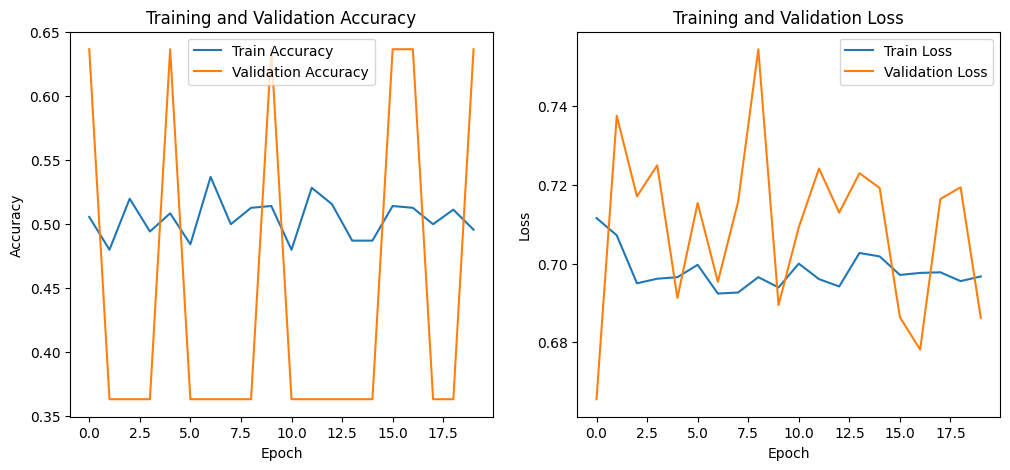

In [ ]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()




#ResNet50

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Создаем модель на основе ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Увеличил dropout для регуляризации
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Замораживаем базовые слои
for layer in base_model.layers:
    layer.trainable = False

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,  # Увеличено число эпох
    batch_size=32
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5094 - loss: 0.7630 - val_accuracy: 0.3632 - val_loss: 0.7088
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.5061 - loss: 0.7219 - val_accuracy: 0.3632 - val_loss: 0.6976
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5475 - loss: 0.6946 - val_accuracy: 0.3632 - val_loss: 0.7077
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4659 - loss: 0.7232 - val_accuracy: 0.6368 - val_loss: 0.6800
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5290 - loss: 0.7036 - val_accuracy: 0.3632 - val_loss: 0.7144
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.4726 - loss: 0.7149 - val_accuracy: 0.3632 - val_loss: 0.7135
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5088 - loss: 0.7136 - val_accuracy: 0.3632 - val_loss: 0.7260
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4744 - loss: 0.7118 - val_accuracy: 0.6

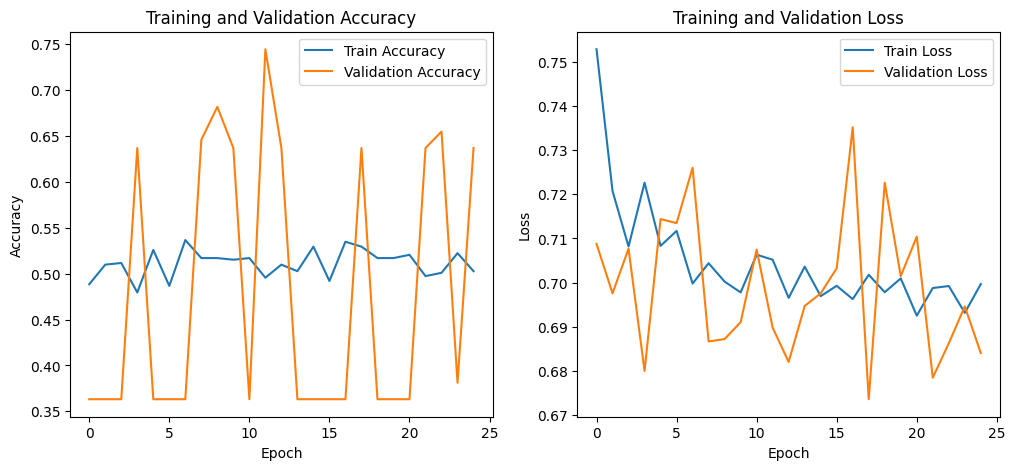

In [ ]:

# Визуализация результатов обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()